In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 

from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.optimize import minimize
import scipy.integrate as integrate
from scipy import special
from scipy.special import erf
from scipy import optimize
from datetime import date
from datetime import datetime

In [2]:
# Preprocessing
amd_quotes = pd.read_csv('amd_quotedata.csv', parse_dates=['Expiration Date'], index_col=['Expiration Date'])
amd_calls = amd_quotes.iloc[:,0:11] # Remove puts
ams_calls = amd_calls.drop('2023-04-06', inplace=True) # Remove date before start date

S0 = 92.3
t0 = date(2023, 4, 8)
amd_calls['Strike/Spot'] = amd_calls['Strike']/S0
amd_calls['Mid'] = (amd_calls['Bid']+amd_calls['Ask'])/2
amd_calls


,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,Open Interest,Strike,Strike/Spot,Mid
Expiration Date,,,,,,,,,,,,,
2023-04-14,AMD230414C00083000,9.72,-0.105,9.55,9.80,166,0.4442,0.9452,0.0172,293,83.0,0.899242,9.675
2023-04-14,AMD230414C00084000,9.05,0.150,8.65,8.85,22,0.4504,0.9287,0.0217,225,84.0,0.910076,8.750
2023-04-14,AMD230414C00085000,8.10,0.075,7.70,7.90,134,0.4427,0.9068,0.0272,867,85.0,0.920910,7.800
2023-04-14,AMD230414C00086000,7.00,-0.125,6.80,7.00,77,0.4352,0.8782,0.0337,569,86.0,0.931744,6.900
2023-04-14,AMD230414C00087000,6.20,-0.125,5.95,6.15,101,0.4259,0.8417,0.0409,544,87.0,0.942579,6.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-19,AMD251219C00120000,21.43,-0.220,20.95,22.30,23,0.4378,0.5719,0.0060,70,120.0,1.300108,21.625
2025-12-19,AMD251219C00125000,19.20,-1.000,19.85,20.80,5,0.4371,0.5475,0.0061,27,125.0,1.354280,20.325
2025-12-19,AMD251219C00130000,17.55,-1.225,18.50,19.45,10,0.4342,0.5238,0.0061,33,130.0,1.408451,18.975


## First maturity

In [3]:
C1 = amd_calls.loc['2023-04-14']
C1 = C1.reset_index(drop=True)
C1

,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,Open Interest,Strike,Strike/Spot,Mid
0,AMD230414C00083000,9.72,-0.105,9.55,9.80,166,0.4442,0.9452,0.0172,293,83.0,0.899242,9.675
1,AMD230414C00084000,9.05,0.150,8.65,8.85,22,0.4504,0.9287,0.0217,225,84.0,0.910076,8.750
2,AMD230414C00085000,8.10,0.075,7.70,7.90,134,0.4427,0.9068,0.0272,867,85.0,0.920910,7.800
3,AMD230414C00086000,7.00,-0.125,6.80,7.00,77,0.4352,0.8782,0.0337,569,86.0,0.931744,6.900
4,AMD230414C00087000,6.20,-0.125,5.95,6.15,101,0.4259,0.8417,0.0409,544,87.0,0.942579,6.050
5,AMD230414C00088000,5.50,-0.050,5.15,5.30,192,0.4269,0.7974,0.0483,457,88.0,0.953413,5.225
6,AMD230414C00089000,4.50,-0.300,4.40,4.50,165,0.4155,0.7456,0.0556,934,89.0,0.964247,4.450
7,AMD230414C00090000,3.76,-0.340,3.70,3.80,817,0.4147,0.6869,0.0622,1864,90.0,0.975081,3.750
8,AMD230414C00091000,3.07,-0.380,3.05,3.15,1194,0.4062,0.6223,0.0677,1272,91.0,0.985915,3.100
9,AMD230414C00092000,2.50,-0.365,2.48,2.50,8647,0.4024,0.5529,0.0714,1637,92.0,0.996750,2.490


In [4]:
def iv(p,K,T,r,S0):
    """
    Calculate implied volatility using Black-Scholes formula
    
    Parameters:
    p (float): Market price(s) of the option
    K (float): Strike price(s) of the option
    T (float): Time to expiry of the option, in years
    r (float): Risk-free interest rate, as a decimal
    S0 (float): Current price of the underlying asset
    """
    
    d1 = lambda sigma: (np.log(S0/K) + (r + 0.5*(sigma**2))*T) / (sigma*np.sqrt(T))
    d2 = lambda sigma: d1(sigma) - sigma*np.sqrt(T)
    option_price = lambda sigma: S0*norm.cdf(d1(sigma)) - K*np.exp(-r*T)*norm.cdf(d2(sigma))
    option_price_diff = lambda sigma: option_price(sigma) - p
    
    return fsolve(option_price_diff, 0.2*np.ones(len(p)))

In [5]:
# Which risk-free interest rate is used?
#iv_diff = lambda r: np.linalg.norm(iv(np.array(amd_calls_t1['Mid']),np.array(amd_calls_t1['Strike']),6/252,r,S0) - np.array(amd_calls_t1['IV']))
#r_ = minimize(iv_diff, 0.01)
#print(r_)

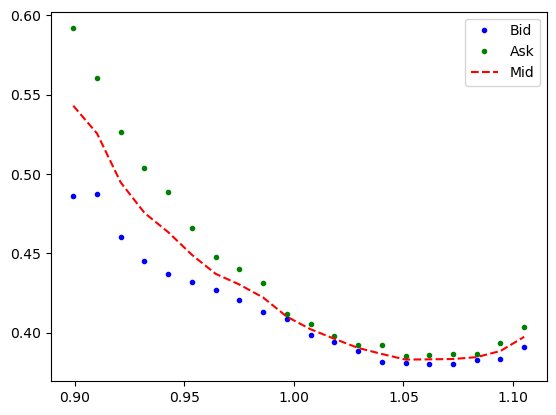

In [6]:
r = 0.01 # TODO: figure out r
ask = np.array(C1['Ask'])
bid = np.array(C1['Bid'])
mid = np.array(C1['Mid'])
K = np.array(C1['Strike'])
numK = len(K)
t1 = 6/252
# Plot data
fig, ax = plt.subplots()
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(bid,K,t1,r,S0)), 'b.', label='Bid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(ask,K,t1,r,S0)), 'g.', label='Ask')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(mid,K,t1,r,S0)), 'r--', label='Mid')
plt.legend()
plt.show()

/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_30239/449844571.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


82.26725329153062


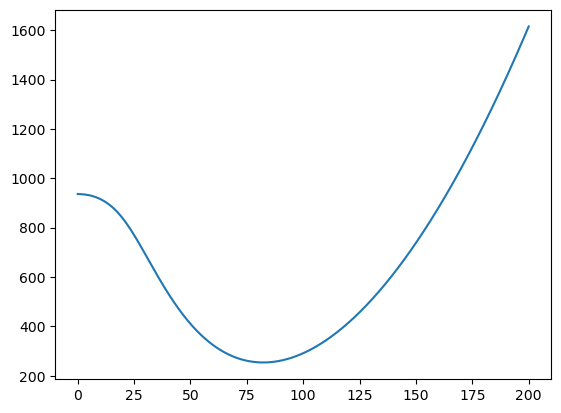

In [7]:
def sigma_objective(sigma,S0,delta_t):
    sqrtt = math.sqrt(delta_t)
    help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)
    B_vec = 0.5*(S0-K)*erf(help_v) + sigma*sqrtt/np.sqrt(2*math.pi)*np.exp(-help_v**2)
    return np.sum((B_vec-mid)**2)


def calculate_sigma0(S0,delta_t):
    res = optimize.minimize_scalar(sigma_objective,args = (S0,delta_t))
    return res.x

sigma0 = calculate_sigma0(S0,6/252)
xx = np.linspace(0,200,1000)
f = lambda x: sigma_objective(x,S0,6/252)
f_ = np.vectorize(f)
plt.plot(xx,f_(xx))
print(sigma0)
P1 = lambda s1: 1
# P1 = lambda s1: 1 if s1 == S0 else 0


#def m_0(s,S0,sigma0,t1): # Joint distribution of S1 and S2
    #return (S0 >= 0) *  (1/(np.sqrt(2*math.pi)*(sigma0*S0))) * np.exp(-1/2*((s-S0)/(sigma0*S0))**2)  *  (1/(np.sqrt(2*math.pi)*sigma0*S0*np.sqrt(t1)) * np.exp(-1/2*((s-S0)/(sigma0*S0*np.sqrt(t1)))**2) )

def m0(s2,s1,delta_t,P1):
    '''
    m0: Joint distribution of (s1,s2)
    P1: Marginal distribution of s1
    '''
    #renormalise m_0 on R^+
    sigma0 = calculate_sigma0(s1,delta_t)
    return norm.pdf(s2,s1,sigma0*np.sqrt(delta_t))/norm.cdf(s1/(sigma0*np.sqrt(delta_t))) * (s1 >= 0) * P1(s1)


def f1(V,omega):
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    l = np.zeros(numK)
    
    for i in range(numK):
        if (V[i]*omega[i] <= delta_C_ask[i]) and (V[i]*omega[i] >= delta_C_bid[i]):
            l[i] = V[i]*V[i]*omega[i]/2
        elif V[i]*omega[i] > delta_C_ask[i]:
            l[i] = delta_C_ask[i]*V[i] - delta_C_ask[i]**2/(2*omega[i])
        elif V[i]*omega[i] < delta_C_bid[i]: 
            l[i] = delta_C_bid[i]*V[i] - delta_C_bid[i]**2/(2*omega[i])
            
    return l


def grad_f1(V,omega):
    """
    Gradient of g1 with respect to V_K
    """
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    g = np.zeros(numK)
    
    for j in range(numK):
        if (V[j]*omega[j] <= delta_C_ask[j]) and (V[j]*omega[j] >= delta_C_bid[j]):
            g[j] = V[j]*omega[j]
        elif V[j]*omega[j] > delta_C_ask[j]:
            g[j] = delta_C_ask[j]
        elif V[j]*omega[j] < delta_C_bid[j]: 
            g[j] = delta_C_bid[j]
    
    return g
    




In [8]:
S0+3*sigma0

339.1017598745919

In [9]:
def I1(alpha,sigma,s1,K1,K2): 
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return 1/2*np.exp((alpha*sigma)**2/2 + alpha*s1) * (special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2)) )
    
def I2(alpha,sigma,s1,K1,K2):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return sigma*np.exp(alpha*s1) * ( 2*(np.exp(A*alpha*sigma-A*A/2) - np.exp(B*alpha*sigma-B*B/2)) + np.sqrt(2*np.pi)*alpha*sigma*np.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2))) )
    
def I3(alpha,sigma,s1,K1,K2,Q):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return np.exp(alpha*s1) *  (2*sigma*(np.exp(A*alpha*sigma-A**2/2) - np.exp(B*alpha*sigma-B**2/2))  +   np.sqrt(2*np.pi)*np.exp(alpha*alpha*sigma*sigma/2)*(alpha*sigma**2-Q+s1) * (erf((B-alpha*sigma)/np.sqrt(2)) - erf((A-alpha*sigma)/np.sqrt(2))) )

def I4(alpha,sigma,s1,K1,K2,K,Q):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma  
    return 2*sigma* (np.exp(alpha*A*sigma-A*A/2)*(sigma*(alpha*sigma+A) - K - Q + 2*s1) + np.exp(-1/2*B*(B-2*alpha*sigma))*(-sigma*(alpha*sigma+B) + K + Q -2*s1))  +  np.sqrt(2*np.pi)*np.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/(np.sqrt(2))) - special.erf((A-alpha*sigma)/(np.sqrt(2))) ) * (sigma**2 - (-alpha*sigma**2+K-s1)*(alpha*sigma**2-Q+s1))
    


In [278]:
def I_u_integrand(s,theta,V,K,s1,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-s1))*m0(s,s1,delta_t,P1)

def I_u(theta,V,K,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_u_integrand,K1,K2,args=(theta,V,K,s1,delta_t,P1) )[0]

def I_u_(theta,V,K,s1,K1,K2,delta_t,P1): 
    #assert(K1 <= K[0] and K2 >= K[-1])
    sigma0 = calculate_sigma0(s1,delta_t)
    sigma = sigma0*np.sqrt(delta_t)
    totI = 0

    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) + numK*theta
        gamma = sum(V[:i+1]*K[:i+1]) - numK*(theta*s1)
        #print(f'alpha = {alpha}')
        #print(f'sigma = {sigma}')

        if (i == -1): 
            newPiece = np.exp(gamma) * I1(alpha,sigma,s1,K1,K[0])
        if (i >= 0 and i < numK-1):
            newPiece = np.exp(gamma) * I1(alpha,sigma,s1,K[i],K[i+1]) # Piecewise integration
        if (i == numK-1):
            newPiece = np.exp(gamma) * I1(alpha,sigma,s1,K[-1],K2)
        
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    return totI


# Check whether symbolic integration is correct
print(I_u(0,np.zeros(numK),K,S0,0,K[0],6/252,P1))
for i in range(0,numK-1):
    print(I_u(0,np.zeros(numK),K,S0,K[i],K[i+1],6/252,P1))
print(I_u(0,np.zeros(numK),K,S0,K[-1],110,6/252,P1))

print("----")

print(I_u_(0,np.zeros(numK),K,S0,0,110,6/252,P1))
print(I_u(0,np.zeros(numK),K,S0,0,110,6/252,P1))

print("---------")
print(I_u_(np.zeros(4),np.zeros(numK),K,S0,0,110,6/252,P1)) # theta can also be a list


TypeError: m0() missing 1 required positional argument: 'P_disc_X1'

In [246]:
def I_h_0_integrand(s,theta,V,K,s1,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-s1))*m0(s,s1,delta_t,P1)*(s-s1)

def I_h_0(theta,V,K,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_h_0_integrand,K1,K2,args=(theta,V,K,s1,delta_t,P1))[0]

def I_h_0_(theta,V,K,s1,K1,K2,delta_t,P1):
    #assert(K1 <= K[0] and K2 >= K[-1])
    sigma0 = calculate_sigma0(s1,delta_t)
    sigma = sigma0*np.sqrt(delta_t)
    totI = 0
    
    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) + numK*theta
        gamma = sum(V[:i+1]*K[:i+1]) - numK*(theta*S0)
        
        if (i == -1): 
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma,s1,K1,K[0])
        if (i >= 0 and i < numK-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma,s1,K[i],K[i+1]) # Piecewise integration
        if (i == numK-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma,s1,K[-1],K2)
        
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    return P1(s1) * totI

# Check whether symbolic integration is correct
print(I_h_0(0,np.zeros(numK),K,S0,0,K[0],6/252,P1))
for i in range(0,numK-1):
    print(I_h_0(0,np.zeros(numK),K,S0,K[i],K[i+1],6/252,P1))
print(I_h_0(0,np.zeros(numK),K,S0,K[-1],110,6/252,P1))

print("----")

print(I_h_0_(0,np.zeros(numK),K,S0,0,110,6/252,P1))
print(I_h_0(0,np.zeros(numK),K,S0,0,110,6/252,P1))

print("---------")
print(I_h_0_(np.zeros(4),np.zeros(numK),K,S0,0,110,6/252,P1)) # theta can also be a list



def I_h_0_grad_integrand(s,theta,V,K,s1,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-S0))*m0(s,s1,delta_t,P1)*(s-s1)*(s-s1)
    
def I_h_0_grad(theta,V,K,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_h_0_grad_integrand,K1,K2,args=(theta,V,K,s1,delta_t,P1))[0]


def I_h_0_hessian_integrand(s,theta,V,K,s1,sigma0,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-s1))*m0(s,s1,sigma0,delta_t,P1)*(s-s1)*(s-s1)*(s-s1)

def I_h_0_hessian(theta,V,K,s1,K1,K2,sigma0,delta_t,P1):
    return integrate.quad(I_h_0_hessian_integrand,K1,K2,args=(theta,V,K,s1,sigma0,delta_t,P1))[0]


-3.872233618827188
-0.21734620096421148
-0.20282523574141822
-0.18501228594141733
-0.16409304877126624
-0.1403395974057791
-0.11410525567106722
-0.08581622581787687
-0.05596022808182871
-0.025072567777474207
0.006279816351738988
0.037515658928093276
0.06805729179355251
0.09734841273727471
0.12487093549423489
0.1501602081003594
0.1728179760709911
0.19252258897252356
0.20903609571929188
0.22220803582426407
1.8662590648912605
----
-1.9157281801156
-1.9157281801159414
---------
[-1.91572818 -1.91572818 -1.91572818 -1.91572818]


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_25036/449844571.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


In [247]:
def I_Q_integrand(s,h0,V,K,Q,s1,delta_t,P1):
    return math.exp(-np.sum(V*np.maximum(s-K,0))+K.size*h0*(s-S0))*m0(s,s1,delta_t,P1)*np.maximum(s-Q,0)

def I_Q(h0,V,K,Q,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_Q_integrand,K1,K2,args=(h0,V,K,Q,s1,delta_t,P1))[0]

def I_Q_(h0,V,K,Q,s1,K1,K2,delta_t,P1):
    #assert(K1 <= K[0] and K2 >= K[-1])
    sigma0 = calculate_sigma0(s1,delta_t)
    sigma = sigma0*np.sqrt(delta_t)
    totI = 0

    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) + numK*h0
        gamma = sum(V[:i+1]*K[:i+1]) - numK*(h0*S0)
        
        if (i == -1): 
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,s1,Q,K[0],Q) * (K[0] >= Q)
        if (i >= 0 and i < numK-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,s1,max(Q,K[i]),K[i+1],Q) * (K[i+1] >= Q)
        if (i == numK-1):
            if (Q <= K[-1]):
                newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,s1,K[-1],K2,Q) 
            else:
                newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,s1,Q,K2,Q) 
            
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece

    return P1(s1) * totI

# Check whether symbolic integration is correct
print(I_Q(0,np.zeros(numK),K,K[0],S0,0,K[0],6/252,P1))
for i in range(0,numK-1):
    print(I_Q(0,np.zeros(numK),K,K[0],S0,K[i],K[i+1],6/252,P1))
print(I_Q(0,np.zeros(numK),K,K[0],S0,K[-1],110,6/252,P1))


print("---------")
print(I_Q_(np.zeros(4),np.zeros(numK),K,K[0],S0,0,110,6/252,P1)) # h0 can also be a list

print("----")
# Check for different Q's
print(I_Q_(0,np.zeros(numK),K,K[0]-10,S0,0,110,6/252,P1))
print(I_Q(0,np.zeros(numK),K,K[0]-10,S0,0,110,6/252,P1))

print(I_Q_(0,np.zeros(numK),K,K[0],S0,0,110,6/252,P1))
print(I_Q(0,np.zeros(numK),K,K[0],S0,0,110,6/252,P1))

print(I_Q_(0,np.zeros(numK),K,K[3],S0,0,110,6/252,P1))
print(I_Q(0,np.zeros(numK),K,K[3],S0,0,110,6/252,P1))

print(I_Q_(0,np.zeros(numK),K,K[-1],S0,0,110,6/252,P1))
print(I_Q(0,np.zeros(numK),K,K[-1],S0,0,110,6/252,P1))

print(I_Q_(0,np.zeros(numK),K,K[-1]+5,S0,0,110,6/252,P1))
print(I_Q(0,np.zeros(numK),K,K[-1]+5,S0,0,110,6/252,P1))



/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_25036/449844571.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


0.0
0.012468033230146263
0.03912994867169328
0.06815011399653668
0.09915777565125697
0.13170903053264046
0.1652968044592132
0.19936368720878123
0.2333171847129944
0.2665468114805733
0.29844233643612
0.32841242076650884
0.35590285251370024
0.380413592336171
0.40151389796886716
0.4188548884037106
0.43217903693354753
0.44132623690786565
0.4462362556117851
0.44694756942206637
3.1755816199312505
---------
[8.3409501 8.3409501 8.3409501 8.3409501]
----
16.164338591971816
16.164338594468763
8.340950097173941
8.340950095702324
6.395552698076312
6.395552698287572
0.5006215612473093
0.5006215612705092
0.05959040871900738
0.05959040817098695


In [248]:
def integrand_G1(s,V,u0,h0,K,omega,S0,delta_t,P1):
    return m0(s,S0,delta_t,P1)*np.exp(-np.sum(V*np.maximum(s-K,0))+(u0-h0*(s-S0))*K.size) 

def G1(V,u0,h0,K,omega,S0,delta_t,P1):
    #expectation = integrate.quad(integrand_G1,0,S0+3*sigma0,args=(V,u0,h0,K,omega,S0,sigma0,t1))[0]
    expectation = I_u_(h0,V,K,S0,50,120,delta_t,P1)*np.exp(-u0) # Gives the same result as the other one! -> Confirms P_sig0 = delta(s-S0)
    #print (f'G1 = {u0 + np.sum(V*mid) + np.sum(f1(V,omega)) + expectation}')
    return u0 + np.sum(V*mid) + np.sum(f1(V,omega)) + expectation

    
def grad_G1(V,u0,h0,K,omega,S0,delta_t,P1):
    """
    Gradient of G_12 with respect to V_K_i
    """
    grad = np.zeros(numK)
    gf1 = grad_f1(V,omega)
    for i in range(numK):
        Q = K[i]
        grad[i] = gf1[i] + mid[i] - I_Q_(h0,V,K,Q,S0,50,120,delta_t,P1)*np.exp(-u0) # Q = K[i] #TODO: can this be sped up by providing Q as a vector?
    
    #print(f'Grad = {grad}')
    #print(f'Grad norm = {np.linalg.norm(grad)}')
    return grad


def Hess_G1(V,u0,h0,K,omega,S0,delta_t,P1):
    '''
    Hessian of G_12
    '''
    H = np.zeros((numK,numK))
    H = np.diag(omega)
    
    for i in range(numK):
        for j in range(numK):
            integrand = lambda s: np.maximum((s-K[i]),0)*np.maximum((s-K[j]),0)*np.exp(-np.sum(V*np.maximum(s-K,0))+(u0-h0*(s-S0))*K.size)*m0(s,S0,sigma0,delta_t,P1)
            H[i,j] += integrate.quad(integrand,50,120)[0] 
    
    return H

    
    

In [249]:
def grad_G1_comparison(V,u0,h0,K,omega,S0,delta_t,P1):
    '''
    Check whether the expression of the gradient is correct, by comparing it to a finite difference approximation
    '''
    grad = grad_G1(V,u0,h0,K,omega,S0,delta_t,P1)
    
    grad_FD = np.zeros(numK)
    eps = 1e-7
    for i in range(numK):
        D = np.zeros(numK)
        D[i] = eps
        grad_FD[i] = (G1(V+D,u0,h0,K,omega,S0,delta_t,P1)-G1(V,u0,h0,K,omega,S0,delta_t,P1))/eps
        
    print(f'Grad = {grad}')
    print(f'Grad_FD = {grad_FD}')

u1, h1, V = 0., 0., [0.]*numK
p0 = np.array([u1] + [h1] + V)
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)

grad_G1_comparison(np.zeros(numK),u0,h0,K,omega_K,S0,6/252,P1)




0.06894511497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894501497715154
12.694112775063108
92.3
0.06894511497715154
12.694112775063108
92.3
0.06894511497715154
12.694112775

/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_25036/449844571.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


In [250]:
#def Hess_G1_comparison(V,u0,h0,K,omega,S0,sigma0,t1):
    #'''
    #Check whether the expression of the Hessian is correct, by comparing it to a finite difference approximation
    #'''
    #Hess = Hess_G1(V,u0,h0,K,omega,S0,sigma0,t1)
    #u = np.ones(numK)
    #eps = 1e-7
    
    #Hess_u = Hess.dot(u)
    #Hess_u_FD = (grad_G1(V+eps*u,u0,h0,K,omega,S0,sigma0,t1)-grad_G1(V,u0,h0,K,omega,S0,sigma0,t1))/eps
    
    #print(f'Hess_u = {Hess_u}')
    #print(f'Hess_u_FD = {Hess_u_FD}')
    

#Hess_G1_comparison(np.zeros(numK),u0,h0,K,omega_K,S0,sigma0,t1)

In [251]:
u1, h1, V = 0., 0., np.array([0.]*numK)
V_prev = np.array([1] *numK)
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)
delta_t = 6/252 #TODO: think about amount of trading days!
P1 = lambda s1: 1

while np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev) > 1e-5:
    V_prev = V
    h0 = optimize.root_scalar(I_h_0_,args=(V,K,S0,50,120,delta_t,P1) ,bracket = [-0.02,0.02],x0=0.00005, fprime = I_h_0_grad, fprime2 = I_h_0_hessian).root
    #u1 = -math.log(1/(I_u(h1,V,K,s1,sigma_0,t1)))
    print(f' h0 = {h0}')
    u0 = np.log(I_u_(h0,V,K,S0,50,120,delta_t,P1))
    print(f' u0 = {u0}')



    #V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,sigma0,t1), method='BFGS', jac= grad_G1, hess=Hess_G1, hessp=None, bounds=None, constraints=(), tol=1e-2, callback=None, options=None).x
    V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,delta_t,P1), method='Newton-CG', jac= grad_G1, hess=None, hessp=None, bounds=None, constraints=(), tol=1e-5, callback=None, options=None).x
    print(f'V = {V}')
    
    print(f'normdiff = {np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev)}')
    print("----------")

    
    
    

/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_25036/449844571.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


 h0 = 0.00015547667682636748
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
 u0 =

0.0031095335365273497
12.694112775063108
92.3
0.04646496484921162
12.694112775063108
92.3
0.08278429376654628
12.694112775063108
92.3
0.1065837312275711
12.694112775063108
92.3
0.12011707211581762
12.694112775063108
92.3
0.12522924185984372
12.694112775063108
92.3
0.12061673378560278
12.694112775063108
92.3
0.1071514061100316
12.694112775063108
92.3
0.08792002946321834
12.694112775063108
92.3
0.06283655843770419
12.694112775063108
92.3
0.030282051641999062
12.694112775063108
92.3
-0.006280257923857375
12.694112775063108
92.3
-0.04471320680373996
12.694112775063108
92.3
-0.08392585524315319
12.694112775063108
92.3
-0.1220133274955981
12.694112775063108
92.3
-0.1582549819419004
12.694112775063108
92.3
-0.19071475046552055
12.694112775063108
92.3
-0.21946105150046077
12.694112775063108
92.3
-0.24437019265626556
12.694112775063108
92.3
-0.265170165632159
12.694112775063108
92.3
-0.28153659497357114
12.694112775063108
92.3
0.0031095335365273497
12.694112775063108
92.3
0.04569707707394077
12

/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_25036/673999581.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  print(f'normdiff = {np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev)}')
/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_25036/673999581.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  while np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev) > 1e-5:


0.04248120684253905
12.694112775063108
92.3
-0.07618965296917063
12.694112775063108
92.3
0.32009765576864185
12.694112775063108
92.3
0.2220662689359537
12.694112775063108
92.3
0.096531914924676
12.694112775063108
92.3
0.22873224435942965
12.694112775063108
92.3
0.2224387060539791
12.694112775063108
92.3
-0.005089144673439912
12.694112775063108
92.3
0.07021356377897686
12.694112775063108
92.3
0.2874248700579977
12.694112775063108
92.3
0.05574076649890191
12.694112775063108
92.3
-0.04758379775192368
12.694112775063108
92.3
-0.012741324154645225
12.694112775063108
92.3
-0.06839922416443878
12.694112775063108
92.3
-0.08065701845526557
12.694112775063108
92.3
-0.21973055481426793
12.694112775063108
92.3
-0.18338837048168224
12.694112775063108
92.3
-0.19443259298833665
12.694112775063108
92.3
-0.29896468036260787
12.694112775063108
92.3
-0.3822117362559055
12.694112775063108
92.3
-0.2525065764576281
12.694112775063108
92.3
V = [ 0.11867086 -0.39628731  0.09803139  0.12553435 -0.13220033  0.0

0.061304866421902846
12.694112775063108
92.3
-0.008239046862554056
12.694112775063108
92.3
0.41743307186874745
12.694112775063108
92.3
0.31381326419139466
12.694112775063108
92.3
0.1646990197712616
12.694112775063108
92.3
0.26946091865533534
12.694112775063108
92.3
0.2319744535159456
12.694112775063108
92.3
-0.02491353301687356
12.694112775063108
92.3
0.03654321744885677
12.694112775063108
92.3
0.25179490920034064
12.694112775063108
92.3
0.015536552958434549
12.694112775063108
92.3
-0.08616201242333373
12.694112775063108
92.3
-0.044576367891465254
12.694112775063108
92.3
-0.09343988441336205
12.694112775063108
92.3
-0.09709035541627827
12.694112775063108
92.3
-0.2301874416020126
12.694112775063108
92.3
-0.1847101846944444
12.694112775063108
92.3
-0.18735029559684296
12.694112775063108
92.3
-0.2847496211074682
12.694112775063108
92.3
-0.3602263844824554
12.694112775063108
92.3
-0.217052856678996
12.694112775063108
92.3
V = [ 0.06954391 -0.42567212  0.10361981  0.14911424 -0.1047619   0.

0.06585023322706378
12.694112775063108
92.3
-0.003494646216608527
12.694112775063108
92.3
0.4221875648176887
12.694112775063108
92.3
0.31819840989690185
12.694112775063108
92.3
0.16856856025094957
12.694112775063108
92.3
0.2728550085903068
12.694112775063108
92.3
0.23491138321421784
12.694112775063108
92.3
-0.022377339366183566
12.694112775063108
92.3
0.03887662584251201
12.694112775063108
92.3
0.25403413150557136
12.694112775063108
92.3
0.017564500057614854
12.694112775063108
92.3
-0.08435428312265537
12.694112775063108
92.3
-0.04300756268698534
12.694112775063108
92.3
-0.09217879250156265
12.694112775063108
92.3
-0.09615342509082493
12.694112775063108
92.3
-0.22962197383839406
12.694112775063108
92.3
-0.18445725179510247
12.694112775063108
92.3
-0.18738524418307861
12.694112775063108
92.3
-0.2850431654008028
12.694112775063108
92.3
-0.3607173303984567
12.694112775063108
92.3
-0.21762506203255633
12.694112775063108
92.3
V = [ 0.06934488 -0.42568221  0.10398915  0.14962985 -0.10428645 

V = [ 0.06914131 -0.42570814  0.10433831  0.15011223 -0.10386361  0.038331
  0.2576033  -0.06115602 -0.21518017  0.23656411  0.10202227 -0.04122004
  0.04937649  0.00420681  0.13376146 -0.04492052  0.00315897  0.09787011
  0.0758332  -0.14304479]
normdiff = 0.0007814325275833448
----------
 h0 = 0.00338710603107998
0.06774212062159961
12.694112775063108
92.3
-0.0013991885647967467
12.694112775063108
92.3
0.424308954001917
12.694112775063108
92.3
0.31997064318446977
12.694112775063108
92.3
0.1698584138496662
12.694112775063108
92.3
0.2737220238261992
12.694112775063108
92.3
0.23539102640716986
12.694112775063108
92.3
-0.022212269951435812
12.694112775063108
92.3
0.0389437510736091
12.694112775063108
92.3
0.2541239235830324
12.694112775063108
92.3
0.01755981668971353
12.694112775063108
92.3
-0.08446245302686457
12.694112775063108
92.3
-0.04324241197265152
12.694112775063108
92.3
-0.09261889963646337
12.694112775063108
92.3
-0.09682570743535852
12.694112775063108
92.3
-0.2305871665578616


0.06890121435280243
12.694112775063108
92.3
-3.5430749541348616e-05
12.694112775063108
92.3
0.4257083455641229
12.694112775063108
92.3
0.32103346274385014
12.694112775063108
92.3
0.17046129635324658
12.694112775063108
92.3
0.2739394141987397
12.694112775063108
92.3
0.23527136351383116
12.694112775063108
92.3
-0.02258394534610371
12.694112775063108
92.3
0.03855085292781277
12.694112775063108
92.3
0.25383931601259985
12.694112775063108
92.3
0.017265739853677783
12.694112775063108
92.3
-0.08477520449103544
12.694112775063108
92.3
-0.043600365037434155
12.694112775063108
92.3
-0.09310791708806122
12.694112775063108
92.3
-0.09748028445175437
12.694112775063108
92.3
-0.2314779052411055
12.694112775063108
92.3
-0.18675206396876332
12.694112775063108
92.3
-0.19010078184518014
12.694112775063108
92.3
-0.2881494629112909
12.694112775063108
92.3
-0.3641138545706302
12.694112775063108
92.3
-0.22109174882036703
12.694112775063108
92.3
V = [ 0.06893665 -0.42574378  0.10467488  0.15057217 -0.10347812

In [252]:
c = np.zeros(numK)
for i in range(numK):
    c[i] = I_Q_(h0,V,K,K[i],S0,50,120,delta_t,P1)*np.exp(-u0)
    print(f'K={K[i]}, C = {c[i]}')

K=83.0, C = 9.682098923692289
K=84.0, C = 8.759159972864094
K=85.0, C = 7.849237717255231
K=86.0, C = 6.958595021179408
K=87.0, C = 6.095255471979563
K=88.0, C = 5.2668902879948405
K=89.0, C = 4.484851003145094
K=90.0, C = 3.7603973201734293
K=91.0, C = 3.0962577379579357
K=92.0, C = 2.4973082863622103
K=93.0, C = 1.9766491728365134
K=94.0, C = 1.5372120469408543
K=95.0, C = 1.1736550645684911
K=96.0, C = 0.8806941943582715
K=97.0, C = 0.651301911250852
K=98.0, C = 0.47700412287967875
K=99.0, C = 0.3463888728394515
K=100.0, C = 0.25034888132777117
K=101.0, C = 0.18128762728690928
K=102.0, C = 0.131618052649058


/var/folders/g9/6f30xmfd3r3br8s467bvpdg40000gn/T/ipykernel_25036/449844571.py:3: RuntimeWarning: divide by zero encountered in divide
  help_v = (K-S0)/(np.sqrt(2)*sqrtt*sigma)


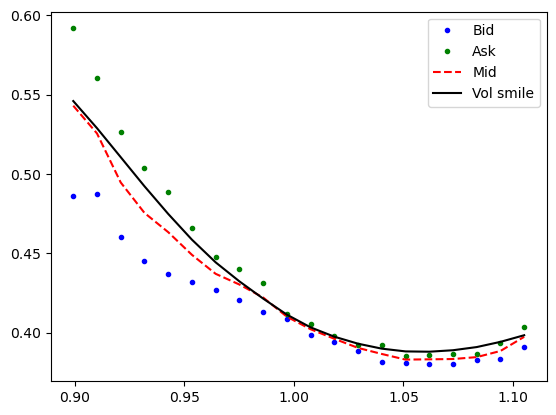

In [253]:
# Plot data
fig, ax = plt.subplots()
T_ = 6/252
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(bid,K,T_,r,S0)), 'b.', label='Bid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(ask,K,T_,r,S0)), 'g.', label='Ask')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(mid,K,T_,r,S0)), 'r--', label='Mid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(c,K,T_,r,S0)), 'k', label='Vol smile')
plt.legend()
plt.show()

## Other maturities

In [39]:
def sigma_objective_(p,C,delta_t,X1,P_disc_X1):
    '''
    C: Pandas dataframe containing all info of that volatility slice (fixed maturity)
    '''
    mid = np.array(C['Mid'])
    K = np.array(C['Strike'])
    sigma0, beta = p[0], p[1]
    sqrtt = math.sqrt(delta_t)
    sigma = lambda s: sigma0*s**beta
    tot = 0
    
    for i in range(K.size): 
        k = K[i]
        help_v = lambda s: (k-s)/(np.sqrt(2)*sqrtt*sigma(s))
        B_vec = lambda s: 0.5*(s-k)*erf(help_v(s)) + sigma(s)*sqrtt/np.sqrt(2*math.pi)*np.exp(-help_v(s)**2)
        B_vec_ = np.vectorize(B_vec)
        expectation_k = np.sum(B_vec_(X1)*P_disc_X1)
        tot += (expectation_k - mid[i])**2 #TODO: compare these two, to check for good fit
        
    #print(f'tot = {tot}')
    return tot


def calculate_sigma0_beta(C,delta_t,X1,P_disc_X1):
    res = optimize.minimize(sigma_objective_,x0 = np.array([0.1, 1]), args = (C,delta_t,X1,P_disc_X1), method='nelder-mead',options={'maxfev': 3000}) # Slow convergence 
    #print(res)
    return res.x

def calculate_sigma(C,delta_t,X1,P_disc_X1):
    sigma0, beta = calculate_sigma0_beta(C,delta_t,X1,P_disc_X1)
    return sigma0*X1**beta


def m0(s2,X1,K,sigma_sqrtdt,P_disc_X1):
    '''
    m0: Joint distribution of (s1,s2)
    X1: Grid of s1's
    P_disc_X1: Discrete marginal distribution of s1
    '''
    #renormalise m_0 on R^+
    return norm.pdf(s2,X1,sigma_sqrtdt)/norm.cdf(X1/(sigma_sqrtdt)) * (X1 >= 0) * P_disc_X1 #TODO: Check whether normalized


def f1(V,omega, C):
    ask = np.array(C['Ask'])
    bid = np.array(C['Bid'])
    mid = np.array(C['Mid'])
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    l = np.zeros(numK)
    
    for i in range(numK):
        if (V[i]*omega[i] <= delta_C_ask[i]) and (V[i]*omega[i] >= delta_C_bid[i]):
            l[i] = V[i]*V[i]*omega[i]/2
        elif V[i]*omega[i] > delta_C_ask[i]:
            l[i] = delta_C_ask[i]*V[i] - delta_C_ask[i]**2/(2*omega[i])
        elif V[i]*omega[i] < delta_C_bid[i]: 
            l[i] = delta_C_bid[i]*V[i] - delta_C_bid[i]**2/(2*omega[i])
            
    return l


def grad_f1(V,omega, C):
    """
    Gradient of g1 with respect to V_K
    """
    ask = np.array(C['Ask'])
    bid = np.array(C['Bid'])
    mid = np.array(C['Mid'])
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    g = np.zeros(numK)
    
    for j in range(numK):
        if (V[j]*omega[j] <= delta_C_ask[j]) and (V[j]*omega[j] >= delta_C_bid[j]):
            g[j] = V[j]*omega[j]
        elif V[j]*omega[j] > delta_C_ask[j]:
            g[j] = delta_C_ask[j]
        elif V[j]*omega[j] < delta_C_bid[j]: 
            g[j] = delta_C_bid[j]
    
    return g



[0.00000000e+000 0.00000000e+000 0.00000000e+000 3.32915966e-204
 5.01965236e-034 1.25342387e-007 1.86805800e-003 5.42727054e-003
 3.25107741e-003 1.25373899e-003 3.71492860e-004 8.66118900e-005
 1.55328127e-005 2.08343383e-006 2.05578827e-007]


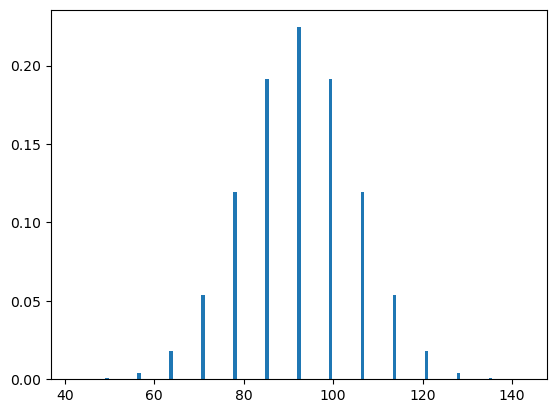

In [52]:
maturities = amd_calls.index.unique()
T0 = maturities[0]
C0 = amd_calls.loc[T0]
C0 = C0.reset_index(drop=True)
T1 = maturities[1]
C1 = amd_calls.loc[T1]
C1 = C1.reset_index(drop=True)

a, b, n = S0-50, S0+50, 15 # Take odd n, such that X1[(n-1)/2] = S0
K1, K2 = a, b
X1 = np.linspace(a,b,n) # Discrete grid

t0 = date(2023, 4, 8)
t1 = maturities[0].to_pydatetime().date()
delta = t1 - t0
delta = delta.days
deltat = delta/252
P1_ = lambda s1: norm.pdf(s1, S0, calculate_sigma(C0,6/252,[S0],[1])*np.sqrt(6/252)) # Marginal distribution of S at t1
P1_disc = lambda x: P1_(x)/sum(P1_(X1))
xx = np.linspace(0,200,1000)
P1_disc_ = np.vectorize(P1_disc)
plt.bar(X1,P1_disc(X1))



u_list, h_list = np.zeros(n), np.zeros(n)
V0 = np.zeros(numK)

# Test for S at t0
#sigma0, beta = calculate_sigma0_beta(C0,6/252,[S0],[1])
#print(sigma0)
#print(beta)
#print(sigma0*S0**beta) # Gives same value (82.267) -> OK

# Test for S at t1
#sigma0, beta = calculate_sigma0_beta(C1,7/365,X1,P1_disc(X1))
#print(sigma0)
#print(beta)
#print(sigma0*X1**beta)


# 
sigma = calculate_sigma(C1,7/365,X1,P1_disc(X1))
sigma_sqrtdt = sigma*np.sqrt(7/365)
print(m0(100,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1)))


In [54]:
def I_u_integrand(s2,theta,V,s1,K,sigma_sqrtdt,P_disc_X1):
    return np.exp(-np.sum(V*np.maximum(s2-K,0))+K.size*theta*(s2-s1))*m0(s2,s1,K,sigma_sqrtdt,P_disc_X1)

def I_u(theta,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2):
    Iu = np.zeros(X1.size)
    for i in range(X1.size): 
        Iu[i] = integrate.quad(I_u_integrand,K1,K2,args=(theta[i],V,X1[i],K,sigma_sqrtdt[i],P_disc_X1[i]))[0]
    return Iu


def I_u_(theta,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2): 
    #assert(K1 <= K[0] and K2 >= K[-1])
    totI = 0

    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) + numK*theta
        gamma = sum(V[:i+1]*K[:i+1]) - numK*(theta*X1)

        if (i == -1): 
            newPiece = np.exp(gamma) * I1(alpha,sigma_sqrtdt,X1,K1,K[0])
        if (i >= 0 and i < numK-1):
            newPiece = np.exp(gamma) * I1(alpha,sigma_sqrtdt,X1,K[i],K[i+1]) # Piecewise integration
        if (i == numK-1):
            newPiece = np.exp(gamma) * I1(alpha,sigma_sqrtdt,X1,K[-1],K2)
        
        newPiece *= P_disc_X1
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    return totI 

K = np.array(C1['Strike'])
sigma_sqrtdt = calculate_sigma(C1,6/252,X1,P1_disc(X1))*np.sqrt(6/252) #TODO: investigate why this one takes so long compared to I_h and I_Q
#print(I_u(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),0,K[0]))
#for i in range(0,numK-1):
    #print(I_u(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),K[i],K[i+1]))
#print(I_u(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),K[-1],110))

print("-----------")
#print(I_u_integrand(100,h_list,V0,X1,K,sigma_sqrtdt,P1_disc(X1)))
print(I_u_(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),0,110)) 
print(I_u(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),0,110))
# I attribute the differences on the boundaries due to inaccuracy in the integral aproximation?


# Test for S at t0
X0 = np.array([S0])
#P0 = lambda s: 1 if s == S0 else 0
P0_disc = np.array([1.])
sigma_sqrtdt = calculate_sigma(C0,6/252,X0,P0_disc)*np.sqrt(6/252)
#print(I_u_(np.zeros(1),V0,X0,np.array(C0['Strike']),sigma_sqrtdt,P0_disc,0,110))

-----------
[9.60010661e-05 7.51742360e-04 4.28899342e-03 1.78293343e-02
 5.40018034e-02 1.19172154e-01 1.91369560e-01 2.00625442e-01
 1.29049431e-01 6.36411211e-02 2.42609740e-02 6.53804253e-03
 1.21706583e-03 1.59536599e-04 1.50260834e-05]
[0.00000000e+00 7.51742360e-04 4.28899342e-03 1.78293343e-02
 5.40018034e-02 1.19172154e-01 1.91369560e-01 2.00625442e-01
 1.29050908e-01 6.37841124e-02 2.48870066e-02 7.13715949e-03
 1.45020395e-03 2.08290417e-04 2.13057324e-05]


2.0605403506976926e-06

In [296]:
def I_h_0_integrand(s,theta,V,K,s1,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-s1))*m0(s,s1,delta_t,P1)*(s-s1)

def I_h_0(theta,V,K,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_h_0_integrand,K1,K2,args=(theta,V,K,s1,delta_t,P1))[0]

def I_h_0_(theta,V,X1,K,sigma_sqrtdt,P_disc_X1,K1,K2):
    #assert(K1 <= K[0] and K2 >= K[-1])
    totI = 0
    
    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) + numK*theta
        gamma = sum(V[:i+1]*K[:i+1]) - numK*(theta*X1)
        
        if (i == -1): 
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma_sqrtdt,X1,K1,K[0])
        if (i >= 0 and i < numK-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma_sqrtdt,X1,K[i],K[i+1]) # Piecewise integration
        if (i == numK-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2(alpha,sigma_sqrtdt,X1,K[-1],K2)
        
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    return totI * P_disc_X1



print(I_h_0_(h_list,V0,X1,np.array(C1['Strike']),sigma_sqrtdt,P1_disc(X1),0,110))
# Test for S at t0
X0 = np.array([S0])
P0_disc = np.array([1.])
sigma_sqrtdt = calculate_sigma(C0,6/252,X0,P0_disc)*np.sqrt(6/252)
print(I_h_0_(np.zeros(1),V0,X0,np.array(C0['Strike']),sigma_sqrtdt,P0_disc,0,110))





def I_h_0_grad_integrand(s,theta,V,K,s1,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-S0))*m0(s,s1,delta_t,P1)*(s-s1)*(s-s1)
    
def I_h_0_grad(theta,V,K,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_h_0_grad_integrand,K1,K2,args=(theta,V,K,s1,delta_t,P1))[0]


def I_h_0_hessian_integrand(s,theta,V,K,s1,sigma0,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-s1))*m0(s,s1,sigma0,delta_t,P1)*(s-s1)*(s-s1)*(s-s1)

def I_h_0_hessian(theta,V,K,s1,K1,K2,sigma0,delta_t,P1):
    return integrate.quad(I_h_0_hessian_integrand,K1,K2,args=(theta,V,K,s1,sigma0,delta_t,P1))[0]

[ 1.10015662e-06  1.20205215e-06  1.01084657e-06  9.67676452e-08
 -6.09200568e-06 -5.17209210e-05 -3.32887780e-04 -1.72127738e-03
 -7.17358139e-03 -2.41010106e-02 -6.52759644e-02 -1.42524798e-01
 -2.50868818e-01 -3.55977088e-01 -4.07208204e-01 -3.75517435e-01
 -2.79166180e-01 -1.67307194e-01 -8.08324121e-02 -3.14829612e-02
 -9.88518321e-03 -2.50214794e-03 -5.10575953e-04 -8.39898569e-05
 -1.11381340e-05]
[-1.91572791]


In [293]:
def I_Q_integrand(s,h0,V,K,Q,s1,delta_t,P1):
    return math.exp(-np.sum(V*np.maximum(s-K,0))+K.size*h0*(s-S0))*m0(s,s1,delta_t,P1)*np.maximum(s-Q,0)

def I_Q(h0,V,K,Q,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_Q_integrand,K1,K2,args=(h0,V,K,Q,s1,delta_t,P1))[0]

def I_Q_(h_list,V,X1,K,Q,sigma_sqrtdt,P_disc_X1,K1,K2):
    #assert(K1 <= K[0] and K2 >= K[-1])
    totI = 0

    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) + numK*h_list
        gamma = sum(V[:i+1]*K[:i+1]) - numK*(h_list*X1)
        
        if (i == -1): 
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma_sqrtdt,X1,Q,K[0],Q) * (K[0] >= Q)
        if (i >= 0 and i < numK-1):
            newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma_sqrtdt,X1,max(Q,K[i]),K[i+1],Q) * (K[i+1] >= Q)
        if (i == numK-1):
            if (Q <= K[-1]):
                newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma_sqrtdt,X1,K[-1],K2,Q) 
            else:
                newPiece = np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma_sqrtdt,X1,Q,K2,Q) 
            
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece

    return totI * P_disc_X1


print(I_Q_(h_list,V0,X1,np.array(C1['Strike']),K[0],sigma_sqrtdt,P1_disc(X1),0,110))
# Test for S at t0
X0 = np.array([S0])
P0_disc = np.array([1.])
sigma_sqrtdt = calculate_sigma(C0,6/252,X0,P0_disc)*np.sqrt(6/252)
K = np.array(C1['Strike'])
print(I_Q_(np.zeros(1),V0,X0,K,K[0],sigma_sqrtdt,P0_disc,0,110))
#print(I_Q_(0,np.zeros(numK),K,K[0],S0,0,110,6/252,P1))

 i = -1: newPiece = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
 i = 0: newPiece = [7.78125602e-05 2.14800750e-04 5.32412261e-04 1.18491287e-03
 2.36783176e-03 4.24855530e-03 6.84475115e-03 9.90147625e-03
 1.28608029e-02 1.49989896e-02 1.57065811e-02 1.47681808e-02
 1.24680335e-02 9.45136406e-03 6.43304418e-03 3.93155205e-03
 2.15743104e-03 1.06300463e-03 4.70282343e-04 1.86813137e-04
 6.66317654e-05 2.13393081e-05 6.13626908e-06 1.58435846e-06
 3.67305499e-07]
 i = 1: newPiece = [1.85512495e-04 5.23925335e-04 1.32861387e-03 3.02525014e-03
 6.18524478e-03 1.13549587e-02 1.87174751e-02 2.77039675e-02
 3.68188011e-02 4.39369848e-02 4.70786230e-02 4.52949842e-02
 3.91299498e-02 3.03529738e-02 2.11410200e-02 1.32215788e-02
 7.42460488e-03 3.74365633e-03 1.69492760e-03 6.89031115e-04
 2.51512149e-04 8.24349738e-05 2.42603123e-05 6.41081974e-06
 1.52111826e-06]
 i = 2: newPiece = [2.38595767e-04 6.91080417e-04 1.79733084e-03 4.19721333e-03
 8.80091090e-03 1.

In [259]:
def G1_(V,u_list,h_list,K,omega,S0,delta_t,P1,P1_disc_X1):
    Iu = I_u_(h_list,V,K,S0,50,120,delta_t,P1)
    expectation = np.sum(Iu*np.exp(-u_list)*P1_disc_X1)
    return np.sum(u_list*P1_disc_X1) + np.sum(V*mid) + np.sum(f1(V,omega)) + expectation

    
def grad_G1_(V,u_list,h_list,K,omega,S0,delta_t,P1,P1_disc_X1):
    """
    Gradient of G_12 with respect to V_K_i
    """
    grad = np.zeros(numK)
    gf1 = grad_f1(V,omega)
    for i in range(numK):
        Q = K[i]
        grad[i] = gf1[i] + mid[i] - np.sum(I_Q_(h_list,V,K,Q,S0,50,120,delta_t,P1)*np.exp(-u_list)*P1_disc_X1) # Q = K[i] #TODO: can this be sped up by providing Q as a vector?
    
    #print(f'Grad = {grad}')
    #print(f'Grad norm = {np.linalg.norm(grad)}')
    return grad

In [260]:
#print(G1_(V,u_list,h_list,K,omega_K,X1,delta_t,P1_,P1_disc(X1)))
#print(grad_G1_(V,u_list,h_list,K,omega_K,X1,delta_t,P1_,P1_disc(X1)))

In [261]:
maturities

DatetimeIndex(['2023-04-14', '2023-04-21', '2023-04-28', '2023-05-05',
               '2023-05-12', '2023-05-19', '2023-05-26', '2023-06-16',
               '2023-07-21', '2023-09-15', '2023-10-20', '2024-01-19',
               '2024-06-21', '2025-01-17', '2025-12-19'],
              dtype='datetime64[ns]', name='Expiration Date', freq=None)

In [262]:
for T1 in maturities[1:2]:
    C1 = amd_calls.loc[T1]
    C1 = C1.reset_index(drop=True)
    
    r = 0.01 # TODO: figure out r
    ask = np.array(C1['Ask'])
    bid = np.array(C1['Bid'])
    mid = np.array(C1['Mid'])
    K = np.array(C1['Strike'])
    
    u_list = np.zeros(n)
    h_list = np.zeros(n)
    
    while np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev) > 1e-5:
        for i in range(n): 
            s1 = X1[i]
            V_prev = V
            h0 = optimize.root_scalar(I_h_0_,args=(V,K,s1,50,120,delta_t,P1) ,bracket = [-0.02,0.02],x0=0.00005, fprime = I_h_0_grad, fprime2 = I_h_0_hessian).root
            h_list[i] = h0
            u0 = np.log(I_u_(h0,V,K,s1,50,120,delta_t,P1))
            u_list[i] = u[0]

        print(f'h_list = {h_list}')
        print(f'u_list = {u_list}')
        #V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,sigma0,t1), method='BFGS', jac= grad_G1, hess=Hess_G1, hessp=None, bounds=None, constraints=(), tol=1e-2, callback=None, options=None).x
        V = optimize.minimize(fun= G1_, x0=V, args=(u_list,h_list,K,omega_K,s1,delta_t,P1_,P1_disc(X1)), method='Newton-CG', jac= grad_G1_, hess=None, hessp=None, bounds=None, constraints=(), tol=1e-5, callback=None, options=None).x
        print(f'V = {V}')

        print(f'normdiff = {np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev)}')
        print("----------")

    
    
    
    # Compute next marginal probability (S at t2)
    P1 = lambda x:(1/(np.sqrt(2*math.pi)*1e-1)) * np.exp(-1/2*((x-S0)/1e-1)**2) * (x >= 0) # Approximation of Dirac delta around 
    P1_disc = lambda x: P1(x)/sum(P1(X1))
    #sum(P1_disc(X1)) = 1